In [1]:
import sys
sys.path.insert(0, '/global/homes/z/zhzhuoqi/.local/cori/3.7-anaconda-2019.10/lib/python3.7/site-packages/TreeCorr-4.1-py3.7-linux-x86_64.egg')

In [2]:
import treecorr
treecorr.__version__

'4.1'

In [3]:
import GCRCatalogs
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import healpy as hp
import camb
import camb.correlations
import matplotlib.colors as clr
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, show, colorbar

In [4]:
def get_healpixel_footprint(ra, dec, nside, nest=False, count_threshold=None):
    pixels = hp.ang2pix(nside, ra, dec, nest=nest, lonlat=True)
    if count_threshold and count_threshold > 1:
        pixels, counts = np.unique(pixels, return_counts=True)
        return pixels[counts >= count_threshold]
    return np.unique(pixels)

In [8]:
filename = '/global/projecta/projectdirs/lsst/groups/CS/cosmoDC2/mass_sheets_behind_z3/cmb_maps/cmblensmap_total_gausshiz_masked.fits'

In [9]:
mapfile = hp.read_map(filename)
print(len(mapfile))

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
201326592


In [10]:
index = np.arange(201326592)
theta, phi = hp.pix2ang(nside=4096, ipix=index)

In [11]:
#theta = 90-np.degrees(theta)
#phi = np.degrees(phi)
print(phi)

[0.78539816 2.35619449 3.92699082 ... 2.35619449 3.92699082 5.49778714]


In [12]:
gc = GCRCatalogs.load_catalog('cosmoDC2')

In [ ]:
data = gc.get_quantities(['ra', 'dec', 'redshift', 'mag_i_lsst'], filters=['mag_i_lsst<22'])

In [24]:
#cut out the CosmoDC2 region from KCMB
nside = 512
healpix_id = get_healpixel_footprint(data['ra'][redshift_mask], data['dec'][redshift_mask], nside) 
print(healpix_id)
npix = hp.nside2npix(nside)
m = np.zeros(npix)
m[healpix_id]=1
new = hp.ud_grade(m, 4096)
cmb_mask = new>0
ra_K = np.degrees(phi[cmb_mask])
dec_K = np.degrees(np.pi/2-theta[cmb_mask])
kcmb = mapfile[cmb_mask]

[2227504 2227519 2227520 ... 2714559 2714575 2714591]


In [25]:
redshift_mask = (data['redshift']<0.6)*(data['redshift']>0.5)

In [82]:
cat_N = treecorr.Catalog(ra=data['ra'][redshift_mask], dec=data['dec'][redshift_mask], ra_units='deg', dec_units='deg', npatch=40)
Npatch = cat_N.patch
Npatch_center = cat_N.get_patch_centers()

In [83]:
cat_K = treecorr.Catalog(ra=ra_K, dec=dec_K, k=kcmb, ra_units='deg', dec_units='deg', patch_centers=Npatch_center)
Kpatch=cat_K.patch

In [88]:
nk = treecorr.NKCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(250./60)*(np.pi/180))

In [124]:
results = []
for i in range(0, 40):
    #remove patch
    Kpatch_mask = np.invert((Kpatch==i))
    Npatch_mask = np.invert((Npatch==i))
    #do the nk
    cat_N_jackknife = treecorr.Catalog(ra=data['ra'][redshift_mask][Npatch_mask], dec=data['dec'][redshift_mask][Npatch_mask], ra_units='deg', dec_units='deg')
    cat_K_jackknife = treecorr.Catalog(ra=ra_K[Kpatch_mask], dec=dec_K[Kpatch_mask], k=kcmb[Kpatch_mask], ra_units='deg', dec_units='deg', patch_centers=Npatch_center)
    nk.process(cat_N_jackknife, cat_K_jackknife)
    R = np.exp(nk.logr)
    xi = np.ndarray.tolist(nk.xi)
    results.append(xi)

Text(0.5, 0, 'ang. sep. [arcmin]')

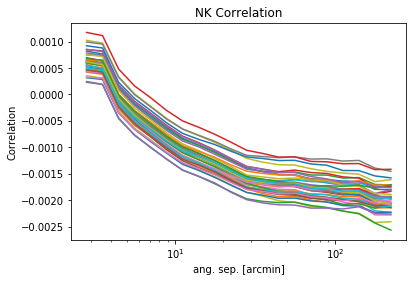

In [127]:
for j in range(0, len(results)):
    plt.plot(60*np.degrees(R), results[j], label=str(j))
plt.xscale('log')
#plt.legend()
plt.title('NK Correlation')
plt.ylabel('Correlation')
plt.xlabel('ang. sep. [arcmin]')
plt.savefig('jackknife.png',dpi=200)

In [128]:
results = np.array(results)

In [137]:
stats = np.transpose(results)

In [144]:
cov = np.zeros((len(stats), len(stats)))
for r in range(0, len(stats)):
    for s in range(0, len(stats)):
        cov[r][s] = np.average((stats[r]-np.average(stats[r]))*(stats[s]-np.average(stats[s])))

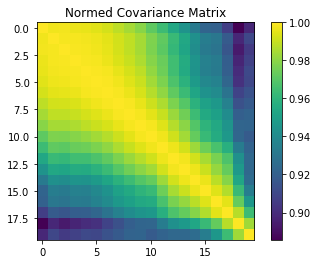

In [158]:
norm_cov = cov.copy()
for i in range(len(cov)):
    for j in range(len(cov)):
        norm_cov[i][j]/=np.sqrt(cov[i][i]*cov[j][j])
plt.imshow(norm_cov)
plt.title('Normed Covariance Matrix')
plt.colorbar()
plt.savefig('cov_jackknife.png',dpi=200)

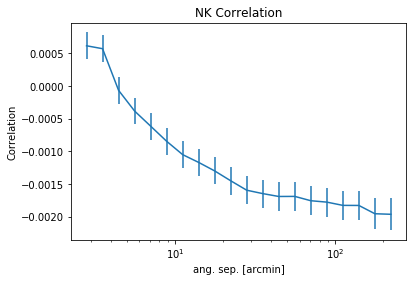

In [156]:
plt.errorbar(60*np.degrees(R), np.average(results,axis=0), yerr=np.sqrt(np.diag(cov)))
plt.xscale('log')
plt.title('NK Correlation')
plt.ylabel('Correlation')
plt.xlabel('ang. sep. [arcmin]')
plt.savefig('NK_jackknife.png',dpi=200)